In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, BatchNormalization
#from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# 读取CSV文件
work_data = pd.read_csv(r"E:\课题\2023暑期科研\data-algo\work_data.csv")
print(work_data.head())

   Unnamed: 0  分类                 名称          日期         热度  上榜时间  levelnchar  \
0           1  娱乐              谢娜怀二胎  2021-01-01  3469652.0   203           2   
1           2  社会  上海通报一英国输入病例病毒基因序列  2021-01-01  3396691.0    69           5   
2           3  其他        开箱2021第一缕阳光  2021-01-01  3365924.0    42           3   
3           4  娱乐               杜淳结婚  2021-01-01  3362505.0   167           1   
4           5  游戏        和平精英代言人新年物资  2021-01-01  3159712.0    28           3   

  sentimentlevel  
0           weak  
1         strong  
2           weak  
3         medium  
4           weak  


In [11]:
# 删除列
work_data = work_data.iloc[:, 1:]

# 将分类重新编码为1到16
nnet_data = work_data.drop(columns=["名称", "日期"])
nnet_data["分类"] = pd.factorize(nnet_data["分类"])[0] + 1
nnet_data["sentimentlevel"] = pd.factorize(nnet_data["sentimentlevel"])[0] + 1

print(nnet_data.head())

   分类         热度  上榜时间  levelnchar  sentimentlevel
0   1  3469652.0   203           2               1
1   2  3396691.0    69           5               2
2   3  3365924.0    42           3               1
3   1  3362505.0   167           1               3
4   4  3159712.0    28           3               1


In [12]:
# 分割特征和目标
X = nnet_data.drop(columns=['热度'])  # 特征
y = nnet_data['热度']  # 目标

# 热度划分等级
threshold_low = np.quantile(y, 0.15)
print(threshold_low)
threshold_high = np.mean(y)
print(threshold_high)

y = np.where(y < threshold_low, 'low', np.where(y > threshold_high, 'high', 'medium'))
print(y)
y = y.reshape(-1, 1)
encoder = OneHotEncoder()
# 进行独热编码
labels = encoder.fit_transform(y).toarray()
print(labels)


174719.8
673648.6043193518
['high' 'high' 'high' ... 'high' 'medium' 'medium']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [13]:
# 数据归一化 (使用Z-score标准化)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=999)

print(X_train)


[[-0.62868231  1.56453792  0.89603681 -1.48289591]
 [ 0.16481785  1.37449845 -0.11962332  1.24647353]
 [-0.62868231  1.1030135  -0.11962332 -1.48289591]
 ...
 [-0.62868231 -0.60734172  0.89603681 -0.11821119]
 [ 2.28081829 -0.85710787 -1.13528345 -1.48289591]
 [ 0.95831802 -0.21097368 -2.15094358  1.24647353]]


In [14]:
# 构建神经网络模型
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # 输入层
    layers.Dense(64, activation='elu'),
    BatchNormalization(),
    layers.Dense(32, activation='elu'),
    BatchNormalization(),
    layers.Dense(16, activation='elu'),
    BatchNormalization(),
    layers.Dense(3, activation="softmax")  # 输出层
])

In [15]:
# 编译模型
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [16]:
# 训练模型
model.fit(
    x=X_train,
    y=y_train,
    epochs=15,
    batch_size=32
)


Epoch 1/30
7887/7887 [==============================] - 32s 4ms/step - loss: 0.8355 - accuracy: 0.6054
Epoch 2/30
7887/7887 [==============================] - 28s 4ms/step - loss: 0.8182 - accuracy: 0.6237
Epoch 3/30
7887/7887 [==============================] - 29s 4ms/step - loss: 0.8136 - accuracy: 0.6307
Epoch 4/30
7887/7887 [==============================] - 28s 4ms/step - loss: 0.8105 - accuracy: 0.6342
Epoch 5/30
7887/7887 [==============================] - 26s 3ms/step - loss: 0.8096 - accuracy: 0.6353
Epoch 6/30
7887/7887 [==============================] - 27s 3ms/step - loss: 0.8076 - accuracy: 0.6375
Epoch 7/30
7887/7887 [==============================] - 28s 4ms/step - loss: 0.8063 - accuracy: 0.6390
Epoch 8/30
7887/7887 [==============================] - 28s 4ms/step - loss: 0.8051 - accuracy: 0.6399
Epoch 9/30
7887/7887 [==============================] - 28s 4ms/step - loss: 0.8044 - accuracy: 0.6403
Epoch 10/30
7887/7887 [==============================] - 27s 3ms/step - l

KeyboardInterrupt: 

In [17]:
# 使用训练好的模型进行预测
nn_pred = model.predict(X_test)


1972/1972 [==============================] - 5s 2ms/step


In [18]:
# 将深度学习模型的输出转换回字符型标签
nn_pred_labels = encoder.inverse_transform(nn_pred)
y_test_labels = encoder.inverse_transform(y_test)


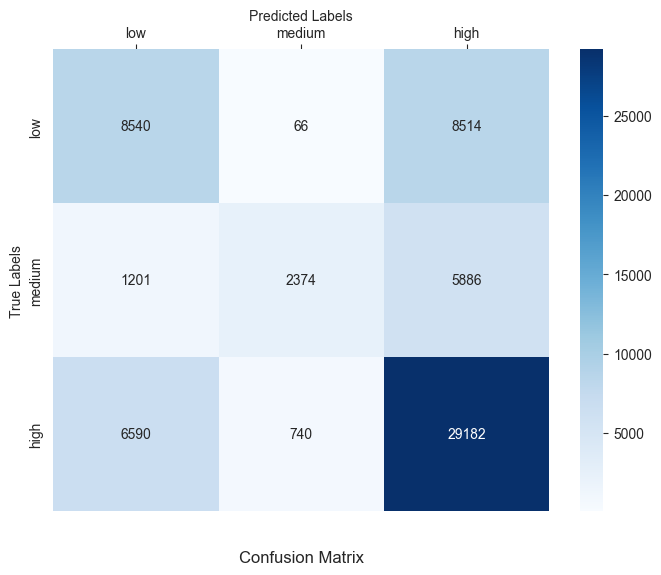

In [19]:
# 构建混淆矩阵
conf_matrix = confusion_matrix(y_test_labels, nn_pred_labels)

# 使用Seaborn可视化混淆矩阵
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# 将 x 轴标签置于图像上方
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.text(0.5, -0.1, 'Confusion Matrix', fontsize=12, ha='center', va='center', transform=ax.transAxes)
plt.show()


In [20]:
# 总体 Accuracy 计算
total_accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print(f"总体 Accuracy: {total_accuracy:.2f}")

# 每个类别的 Accuracy 计算
class_accuracy = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
print("每个类别的 Accuracy:")
for idx, acc in enumerate(class_accuracy):
    print(f"{idx}: {acc:.2f}")

总体 Accuracy: 0.64
每个类别的 Accuracy:
0: 0.50
1: 0.25
2: 0.80
